In [1]:
# 필요한 패키지 불러오기
from bs4 import BeautifulSoup
from selenium import webdriver as wd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import re

import pandas as pd
pd.set_option('display.max_rows', None) # 데이터 프레임 raw 값 보기 제한 없앰.

In [2]:
# 인스타 단어 검색 함수
def insta_searching(word):
    url = "https://www.instagram.com/explore/tags/" + word
    return url

In [3]:
# 크롬 브라우저 열기 
driver = webdriver.Chrome()
driver.get('https://www.instagram.com')
time.sleep(2)  # 정보를 들고 오기까지의 일정 시간을 정해줌

In [4]:
# 인스타 계정 로그인
email =  # '본인계정 이메일 및 아이디'
input_id = driver.find_elements_by_css_selector('input._2hvTZ.pexuQ.zyHYP')[0]
input_id.clear()
input_id.send_keys(email)

password = # '비밀번호'
input_pw = driver.find_elements_by_css_selector('input._2hvTZ.pexuQ.zyHYP')[1]
input_pw.clear()
input_pw.send_keys(password)
input_pw.submit()

In [5]:
# 검색어 검색 
word = "서울호캉스"
url = insta_searching(word)
driver.get(url)

In [6]:
# 첫 번째 게시물 클릭 동작하는 함수 
def select_first(driver):
    first = driver.find_element_by_css_selector("div._9AhH0")
    first.click()
    time.sleep(3)
    
select_first(driver)

In [7]:
# 인스타그램 페이지에서 개발자모드에 들어가서 path를 확인하고 본문 내용, 해시태그, 작성일자, 좋아요 수, 위치 정보를 들고 와서 저장합니다.

In [10]:
# 게시물 클릭하여 크롤링하는 함수 작성 
def get_content(driver):
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    # 본문내용
    try:
        content = soup.select('div.C4VMK > span')[0].text
    except:
        content = ' '
    # 해시태그
    tags = re.findall(r'#[^\s#,\\]+', content)
    # 작성일자
    date = soup.select('time.FH9sR.Nzb55')[0]['datetime'][:10]
    # 좋아요
    try:
        like = soup.select('div.Nm9Fw > a')[0].text[4:-1]   
    except:
        like = 0
    # 위치
    try:
        place = soup.select('div.M30cS')[0].text
    except:
        place = ''
    
    data = [content, date, like, place, tags]
    return data

get_content(driver)

['뉴욕시 장충동 🥐☕️여행 갔다올때마다 그나라 신문 꼭 챙겨왔는데 뉴욕타임즈 너무 오랜만에 본느낌 신문이 반가울줄이야.. #신라호텔 #신라호텔서울 #스윗제니호텔 #호텔조식 #일상 #서울호캉스 #주말 ..',
 '2021-05-23',
 '995',
 'The Shilla Hotels & Resorts - 신라호텔',
 ['#신라호텔', '#신라호텔서울', '#스윗제니호텔', '#호텔조식', '#일상', '#서울호캉스', '#주말']]

In [11]:
# 한 페이지에서 크롤링하고 다음  페이지로 넘어가는 코드 작성 
def move_next(driver):
    
    right = driver.find_element_by_css_selector('a.coreSpriteRightPaginationArrow')
    right.click()
    time.sleep(3)
    
move_next(driver)

In [13]:
# 본격적 크롤링 시작 
word = '서울호캉스'
url = insta_searching(word)

driver.get(url)
time.sleep(3)

select_first(driver)

results = []

target = 1000
for i in range(target):
    
    try:
        data = get_content(driver)
        results.append(data)
        move_next(driver)
    except:
        time.sleep(2)
        move_next(driver)
    
print(results[:2])

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"a.coreSpriteRightPaginationArrow"}
  (Session info: chrome=90.0.4430.212)


- 결국.. 1000개를 채우지 못하고 962개에서 끊어짐

In [16]:
# 크롤링 결과 확인 및 데이터 프레임으로 정리 
results_df = pd.DataFrame(results)
results_df.columns = ['content', 'data', 'like', 'place', 'tags']
results_df

,content,data,like,place,tags
0,뉴욕시 장충동 🥐☕️여행 갔다올때마다 그나라 신문 꼭 챙겨왔는데 뉴욕타임즈 너무 오...,2021-05-23,995,The Shilla Hotels & Resorts - 신라호텔,"[#신라호텔, #신라호텔서울, #스윗제니호텔, #호텔조식, #일상, #서울호캉스, ..."
1,💙서초에 있다는 세젤예 프라이빗 스파&풀 펜트하우스💙아침엔 청량청량 뽀오얀 분위기+...,2021-04-21,"3,810",,"[#소설호텔펜트하우스, #서울펜션, #서울숙소, #서울숙소추천, #서울호캉스, #서..."
2,결혼기념일 다가오는 이맘때쯤은 매년 신라에서 하루 자고 비행기 타는 코스였는데......,2021-05-23,"1,173",The Shilla Hotels & Resorts - 신라호텔,"[#팔이새카만것은기분탓인가, #스윗제니, #스윗제니호텔, #서울호캉스, #신라호텔,..."
3,칭구들이 도대체 언제 올리냐고 몇 번이나 물어봤는데 드디어 올리는 그 날의 사진🧡ㅋ...,2021-05-16,509,"Seoul, Korea",[]
4,4월말 스트레스 만땅인 약 한달간의 기획을 끝내고 4일 휴가를 내고 호캉스를 했습니...,2021-05-26,608,Park Hyatt Seoul - 파크하얏트서울,"[#서울호텔, #서울호캉스, #서울호텔추천, #호캉스, #호캉스추천, #셀카, #거..."
...,...,...,...,...,...
957,제주도 말고 경기도 유채꽃 ......#안성팜랜드 #안성 #유채꽃,2021-04-30,137,NH 안성팜랜드,"[#안성팜랜드, #안성, #유채꽃]"
958,바람에 흩날리는 앞머리...😕.......#안성팜랜드 #유채꽃 #안성 #경기도가볼만한곳,2021-04-30,139,NH 안성팜랜드,"[#안성팜랜드, #유채꽃, #안성, #경기도가볼만한곳]"
959,✔:.가브리엘 호보백💕고객님 후기 감사합니다🙇🏻‍♀️찐과 가죽 동일피 사용으로정말 ...,2021-04-30,298,,[]
960,#beforesunset,2021-04-29,396,"Seoul, South Korea",[#beforesunset]


In [17]:
# 브라우져 종료 
driver.quit()

In [18]:
# 파일 저장 (to_csv)
results_df.to_csv("seoul_hotels.csv")

In [2]:
# csv 파일 불러오기
seoul = pd.read_csv("datas/seoul_hotels.csv")
seoul.head()

,Unnamed: 0,content,data,like,place,tags
0,0,뉴욕시 장충동 🥐☕️여행 갔다올때마다 그나라 신문 꼭 챙겨왔는데 뉴욕타임즈 너무 오...,2021-05-23,995,The Shilla Hotels & Resorts - 신라호텔,"['#신라호텔', '#신라호텔서울', '#스윗제니호텔', '#호텔조식', '#일상'..."
1,1,💙서초에 있다는 세젤예 프라이빗 스파&풀 펜트하우스💙아침엔 청량청량 뽀오얀 분위기+...,2021-04-21,"3,810",NaN,"['#소설호텔펜트하우스', '#서울펜션', '#서울숙소', '#서울숙소추천', '#..."
2,2,결혼기념일 다가오는 이맘때쯤은 매년 신라에서 하루 자고 비행기 타는 코스였는데......,2021-05-23,"1,173",The Shilla Hotels & Resorts - 신라호텔,"['#팔이새카만것은기분탓인가', '#스윗제니', '#스윗제니호텔', '#서울호캉스'..."
3,3,칭구들이 도대체 언제 올리냐고 몇 번이나 물어봤는데 드디어 올리는 그 날의 사진🧡ㅋ...,2021-05-16,509,"Seoul, Korea",[]
4,4,4월말 스트레스 만땅인 약 한달간의 기획을 끝내고 4일 휴가를 내고 호캉스를 했습니...,2021-05-26,608,Park Hyatt Seoul - 파크하얏트서울,"['#서울호텔', '#서울호캉스', '#서울호텔추천', '#호캉스', '#호캉스추천..."


In [3]:
seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  962 non-null    int64 
 1   content     962 non-null    object
 2   data        962 non-null    object
 3   like        955 non-null    object
 4   place       618 non-null    object
 5   tags        962 non-null    object
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


<AxesSubplot:>

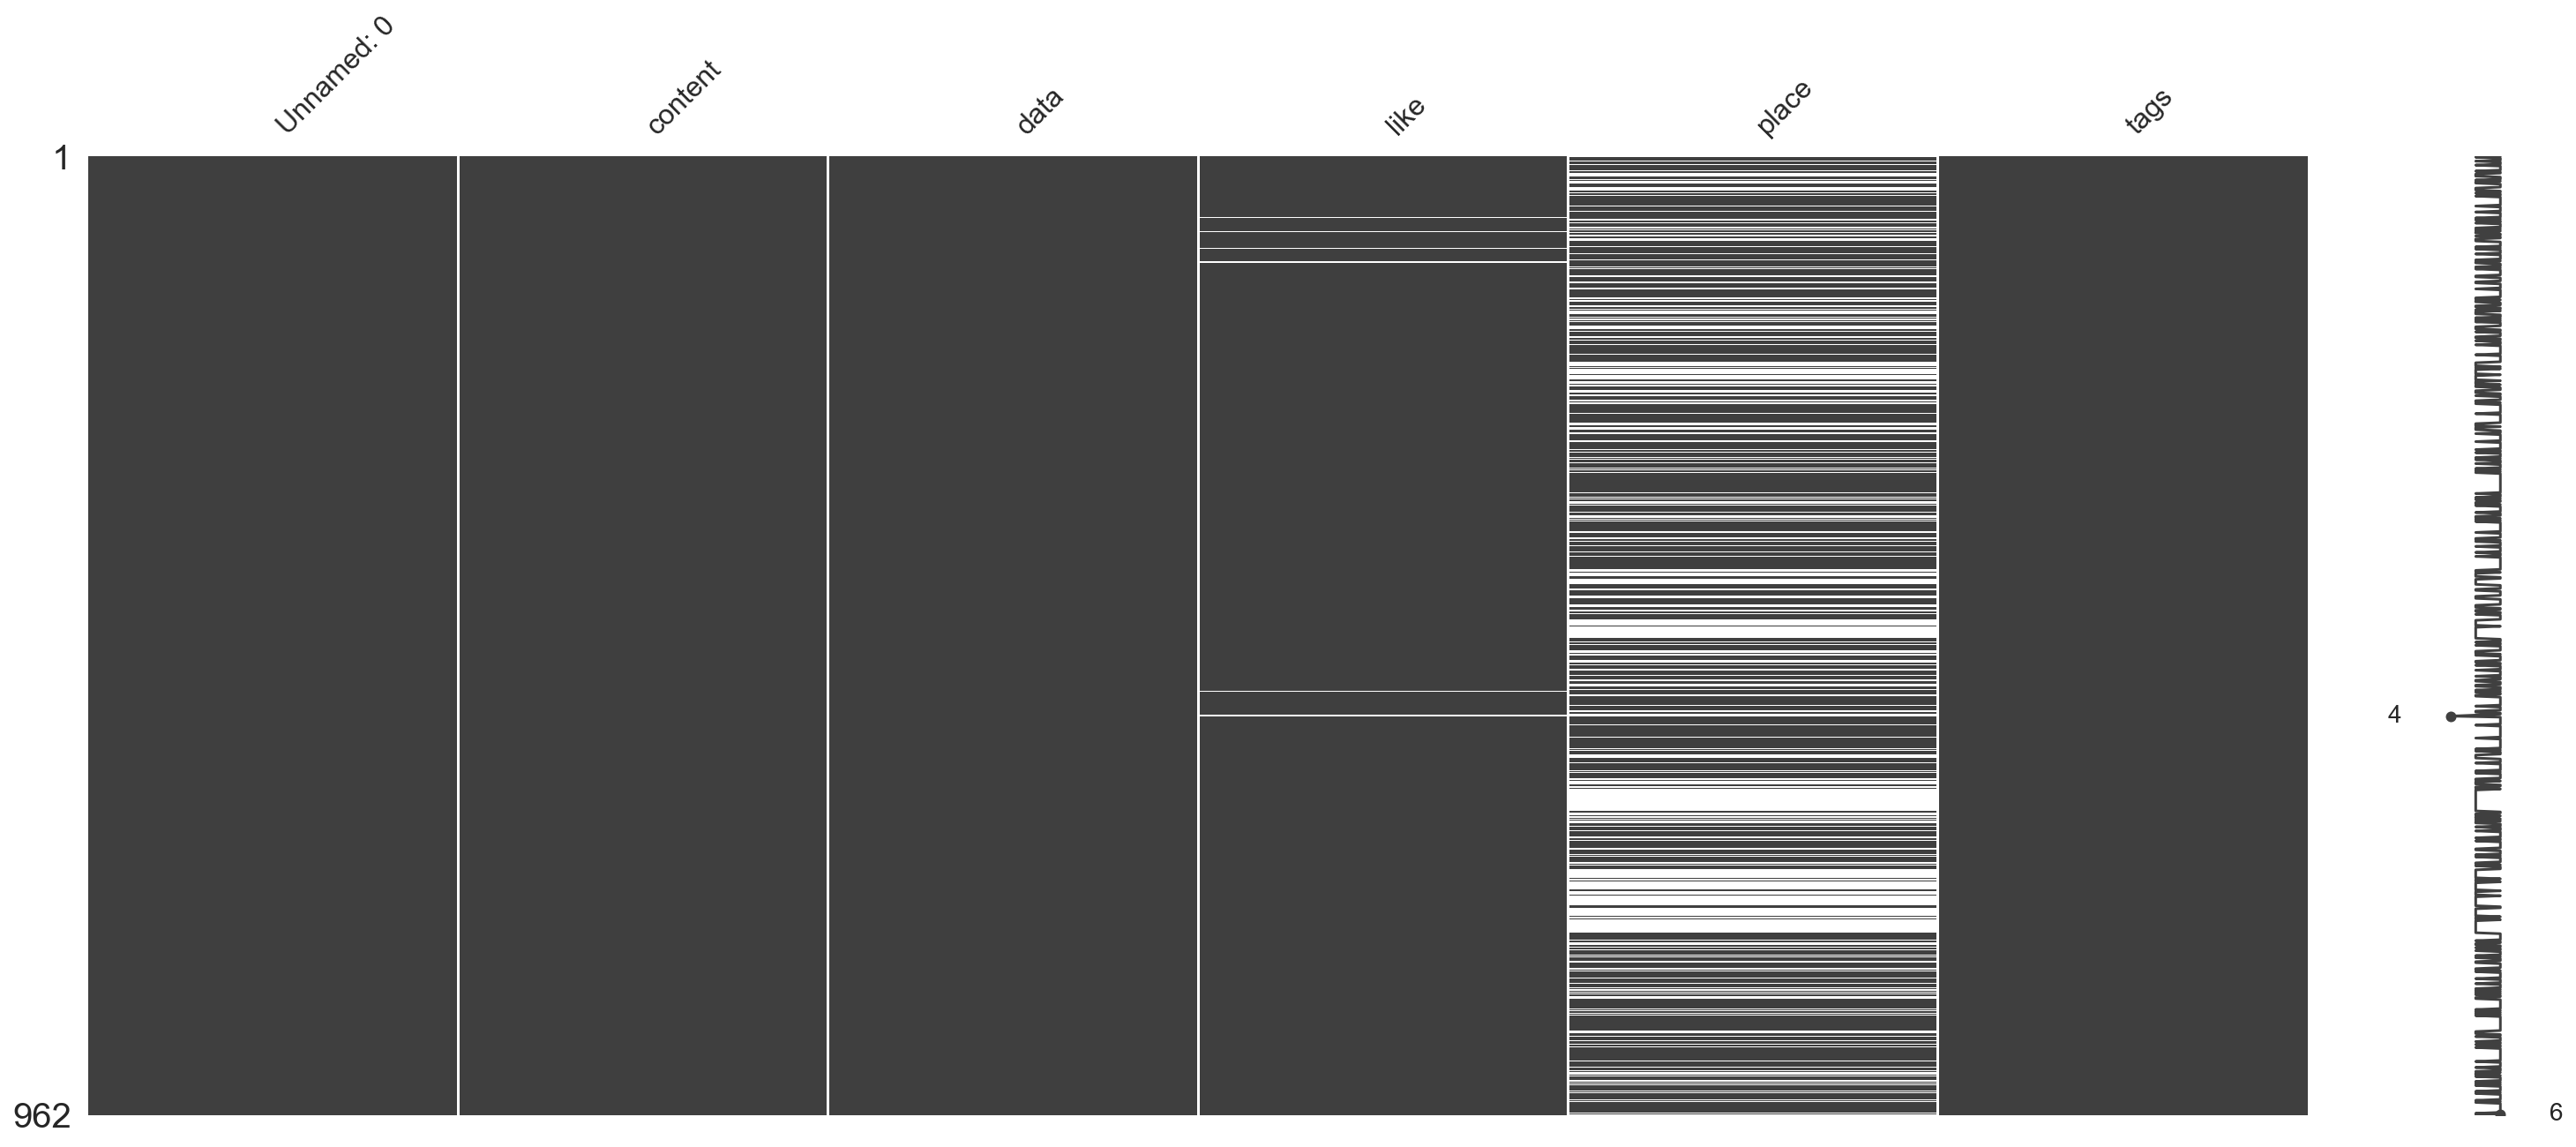

In [4]:
# 이터 결측치 확인 
import missingno
missingno.matrix(seoul)

In [5]:
seoul['place'].value_counts(sort=True, ascending=False)

Park Hyatt Seoul - 파크하얏트서울                                       33
Grand Hyatt Seoul                                                33
InterContinental Grand Seoul Parnas                              33
Seoul, Korea                                                     31
Mondrian Seoul Itaewon                                           29
The Shilla Hotels & Resorts - 신라호텔                               25
L'Escape Hotel                                                   22
SIGNIEL - 시그니엘                                                   16
InterContinental Seoul COEX                                      15
서울 웨스틴조선호텔 The Westin Josun Seoul                                14
Andaz Seoul Gangnam - 안다즈 서울 강남                                  13
Holiday Inn Express Seoul Hongdae                                12
Fairmont Ambassador Seoul - 페어몬트 앰배서더 서울                         12
Banyan Tree - Club & Spa - Seoul                                 11
Sheraton Seoul D Cube City Hotel                

In [6]:
place = pd.DataFrame(seoul['place'].value_counts())
place

,place
Park Hyatt Seoul - 파크하얏트서울,33
Grand Hyatt Seoul,33
InterContinental Grand Seoul Parnas,33
"Seoul, Korea",31
Mondrian Seoul Itaewon,29
The Shilla Hotels & Resorts - 신라호텔,25
L'Escape Hotel,22
SIGNIEL - 시그니엘,16
InterContinental Seoul COEX,15
서울 웨스틴조선호텔 The Westin Josun Seoul,14


In [7]:
from pyecharts import Pie

keys = list(place["place"][:10].keys())
values = list(place["place"][:10].values)

pie = Pie("Hotel Top 10 ")
pie.add("", keys, values, is_randome=True, radius=[50, 90], rosetype='radius', is_legend_show=False,
       is_label_show=True)

pie

- 크롤링을 해보고 그래프를 그려본 결과 'Park Hyatt Seoul', 'Grand Hyatt Seoul' 인스타그램에 언급이 가장 많았다. 
- 우선 로컬 서버로 크롤링한 것이라, 중간에 인스타 서버에서 막은 것 같다. 우분투 서버에 우선 해보고, 전 게시물들을 다시 돌려봐야겠다. 

In [8]:
# 보조강사님의 피드백
# 인스타 자료를 통해 챗봇으로 서비스 
# 서비스시 시간대 별로 추천 (검색량 기준)
# 만약 호텔 순위를 정한다면 시간대는 주 단위로 
# 호텔 리뷰어를 먼저 만드는게 우선  - 호텔사이트 크롤링이 우선 인스타 크롤링이나 자료 검색은 나중에 

In [9]:
# 해시태그로 워드클라우드 만들어보기

In [10]:
seoul['tags']

0      ['#신라호텔', '#신라호텔서울', '#스윗제니호텔', '#호텔조식', '#일상'...
1      ['#소설호텔펜트하우스', '#서울펜션', '#서울숙소', '#서울숙소추천', '#...
2      ['#팔이새카만것은기분탓인가', '#스윗제니', '#스윗제니호텔', '#서울호캉스'...
3                                                     []
4      ['#서울호텔', '#서울호캉스', '#서울호텔추천', '#호캉스', '#호캉스추천...
5      ['#월호텔', '#서울숙소', '#서울숙소추천', '#서울호캉스', '#서울호텔'...
6                                    ['#마랑브로우', '#콤보눈썹']
7                           ['#살롱드해변', '#속초카페', '#속초여행']
8                                                     []
9      ['#서울호캉스', '#서울호텔', '#그랜드인터컨티넨탈서울파르나스', '#특가찬스...
10                     ['#비스타워커힐', '#refreshingvividly']
11     ['#DelightfulExperience', '#인터컨티넨탈서울코엑스', '#스카...
12                                                    []
13     ['#안다즈서울강남', '#얼리써머플래시세일⠀✅', '#AndazSeoulGangn...
14     ['#UnveilTrueLuxury', '#IHG리워즈클럽', '#그랜드인터컨티넨탈...
15                                                    []
16                                                    []
17     ['#평일외출', '#호캉스', '#그랜드하

In [11]:
# split 함수로 나누기 
tags_total = []
for tags in seoul['tags']:
    tags_list = tags[2:-2].split("', '")
    for tag in tags_list:
        tags_total.append(tag)
print(tags_total)

['#신라호텔', '#신라호텔서울', '#스윗제니호텔', '#호텔조식', '#일상', '#서울호캉스', '#주말', '#소설호텔펜트하우스', '#서울펜션', '#서울숙소', '#서울숙소추천', '#서울호캉스', '#서울호텔', '#서울호텔추천', '#소설호텔', '#호텔소설', '#서울데이트', '#서울데이트코스', '#서울가볼만한곳', '#서울핫플_데이트', '#서울핫플_서초', '#팔이새카만것은기분탓인가', '#스윗제니', '#스윗제니호텔', '#서울호캉스', '#신라호텔', '#어반아일랜드', '', '#서울호텔', '#서울호캉스', '#서울호텔추천', '#호캉스', '#호캉스추천', '#셀카', '#거울샷', '#이자벨마랑', '#보테가베네타', '#휴가', '#ootd', '#ootdfashion', '#fashion', '#fashionblogger', '#호텔블로거', '#호텔블로그', '#호텔리뷰', '#월호텔', '#서울숙소', '#서울숙소추천', '#서울호캉스', '#서울호텔', '#서울호텔추천', '#서울파티룸', '#서울파티룸추천', '#우정파티', '#서울수영장호텔', '#서울데이트', '#서울데이트코스', '#서울가볼만한곳', '#마랑브로우', '#콤보눈썹', '#살롱드해변', '#속초카페', '#속초여행', '', '#서울호캉스', '#서울호텔', '#그랜드인터컨티넨탈서울파르나스', '#특가찬스', '#즐거운호캉스', '#너무너무좋다', '#또가고싶다', '#호캉스', '#힐링', '#일상', '#호텔그램', '#여행기록', '#비스타워커힐', '#refreshingvividly', '#DelightfulExperience', '#인터컨티넨탈서울코엑스', '#스카이라운지', '#이탈리안런치', '#스카이런치', '', '#안다즈서울강남', '#얼리써머플래시세일⠀✅', '#AndazSeoulGangnam', '#프로필링크', '#UnveilTrueLuxury', '#IHG리워즈클럽', '#그랜드인터컨티넨탈서울파르나스', '', '', 

In [12]:
# 위의 해시태그를 활용하여 빈도수 계산 후 빈도수가 높은 순으로 보기 쉽게 정리하기
from collections import Counter
tag_counts = Counter(tags_total)

tag_counts.most_common(100)

[('#서울호캉스', 418),
 ('', 293),
 ('#호캉스', 216),
 ('#비스타워커힐서울', 147),
 ('#명품블라우스', 119),
 ('#롯데호텔월드', 118),
 ('#명품원피스', 117),
 ('#데이트룩', 117),
 ('#기념일선물', 117),
 ('#여자명품옷', 117),
 ('#하객패션', 117),
 ('#나들이룩', 117),
 ('#마인', 117),
 ('#강원도여행', 117),
 ('#고성맛집', 117),
 ('#상무지구핫플', 117),
 ('#나인원한남', 117),
 ('#신라호텔콘티넨탈', 117),
 ('#서래마을카페', 117),
 ('#해운대트럼프월드', 117),
 ('#청담동피부과', 117),
 ('#청담벨뷰', 117),
 ('#이색카페', 117),
 ('#청담동어퍼하우스', 117),
 ('#롯데백화점잠실점', 117),
 ('#포일센트럴푸르지오', 117),
 ('#포일동맛집', 117),
 ('#서울호텔', 100),
 ('#호캉스추천', 40),
 ('#안다즈서울강남', 35),
 ('#일상', 33),
 ('#서울신라호텔', 32),
 ('#호텔', 32),
 ('#서울호텔추천', 31),
 ('#서울수영장호텔', 31),
 ('#글래드여의도', 31),
 ('#jw메리어트서울', 31),
 ('#호텔수영장', 30),
 ('#회개와_거룩함', 29),
 ('#주님의_길을_예비하라', 29),
 ('#메시아께서_오신다', 29),
 ('#주말나들이', 29),
 ('#주말데이트', 29),
 ('#진도쏠비치리조트', 29),
 ('#쏠비치진도', 29),
 ('#골든튤립해운대', 29),
 ('#제주신라호텔', 29),
 ('#신라스테이광화문', 29),
 ('#신라스테이역삼', 29),
 ('#호텔페이토삼성', 29),
 ('#제주도호텔추천', 29),
 ('#트로피컬하이드어웨이', 29),
 ('#산방산', 29),
 ('#송악산', 29),
 ('#제주호캉스', 29),

In [13]:
# 시각화를 위해 패키지 불러오기
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import sys

In [14]:
# 막대그래프에 사용될 글꼴을 설
if sys.platform in ['win32', 'win64']:
    font_name = 'malgun gothic'
elif sys.platform == 'darwin':
    font_name = 'AppleGothic'
    
rc('font', family = font_name)

In [15]:
# tag와 counts만 선택하여 상위 50개의 데이터를 선정
tag_counts_df = pd.DataFrame(tag_counts.most_common(100))
tag_counts_df.columns = ['tags', 'counts']

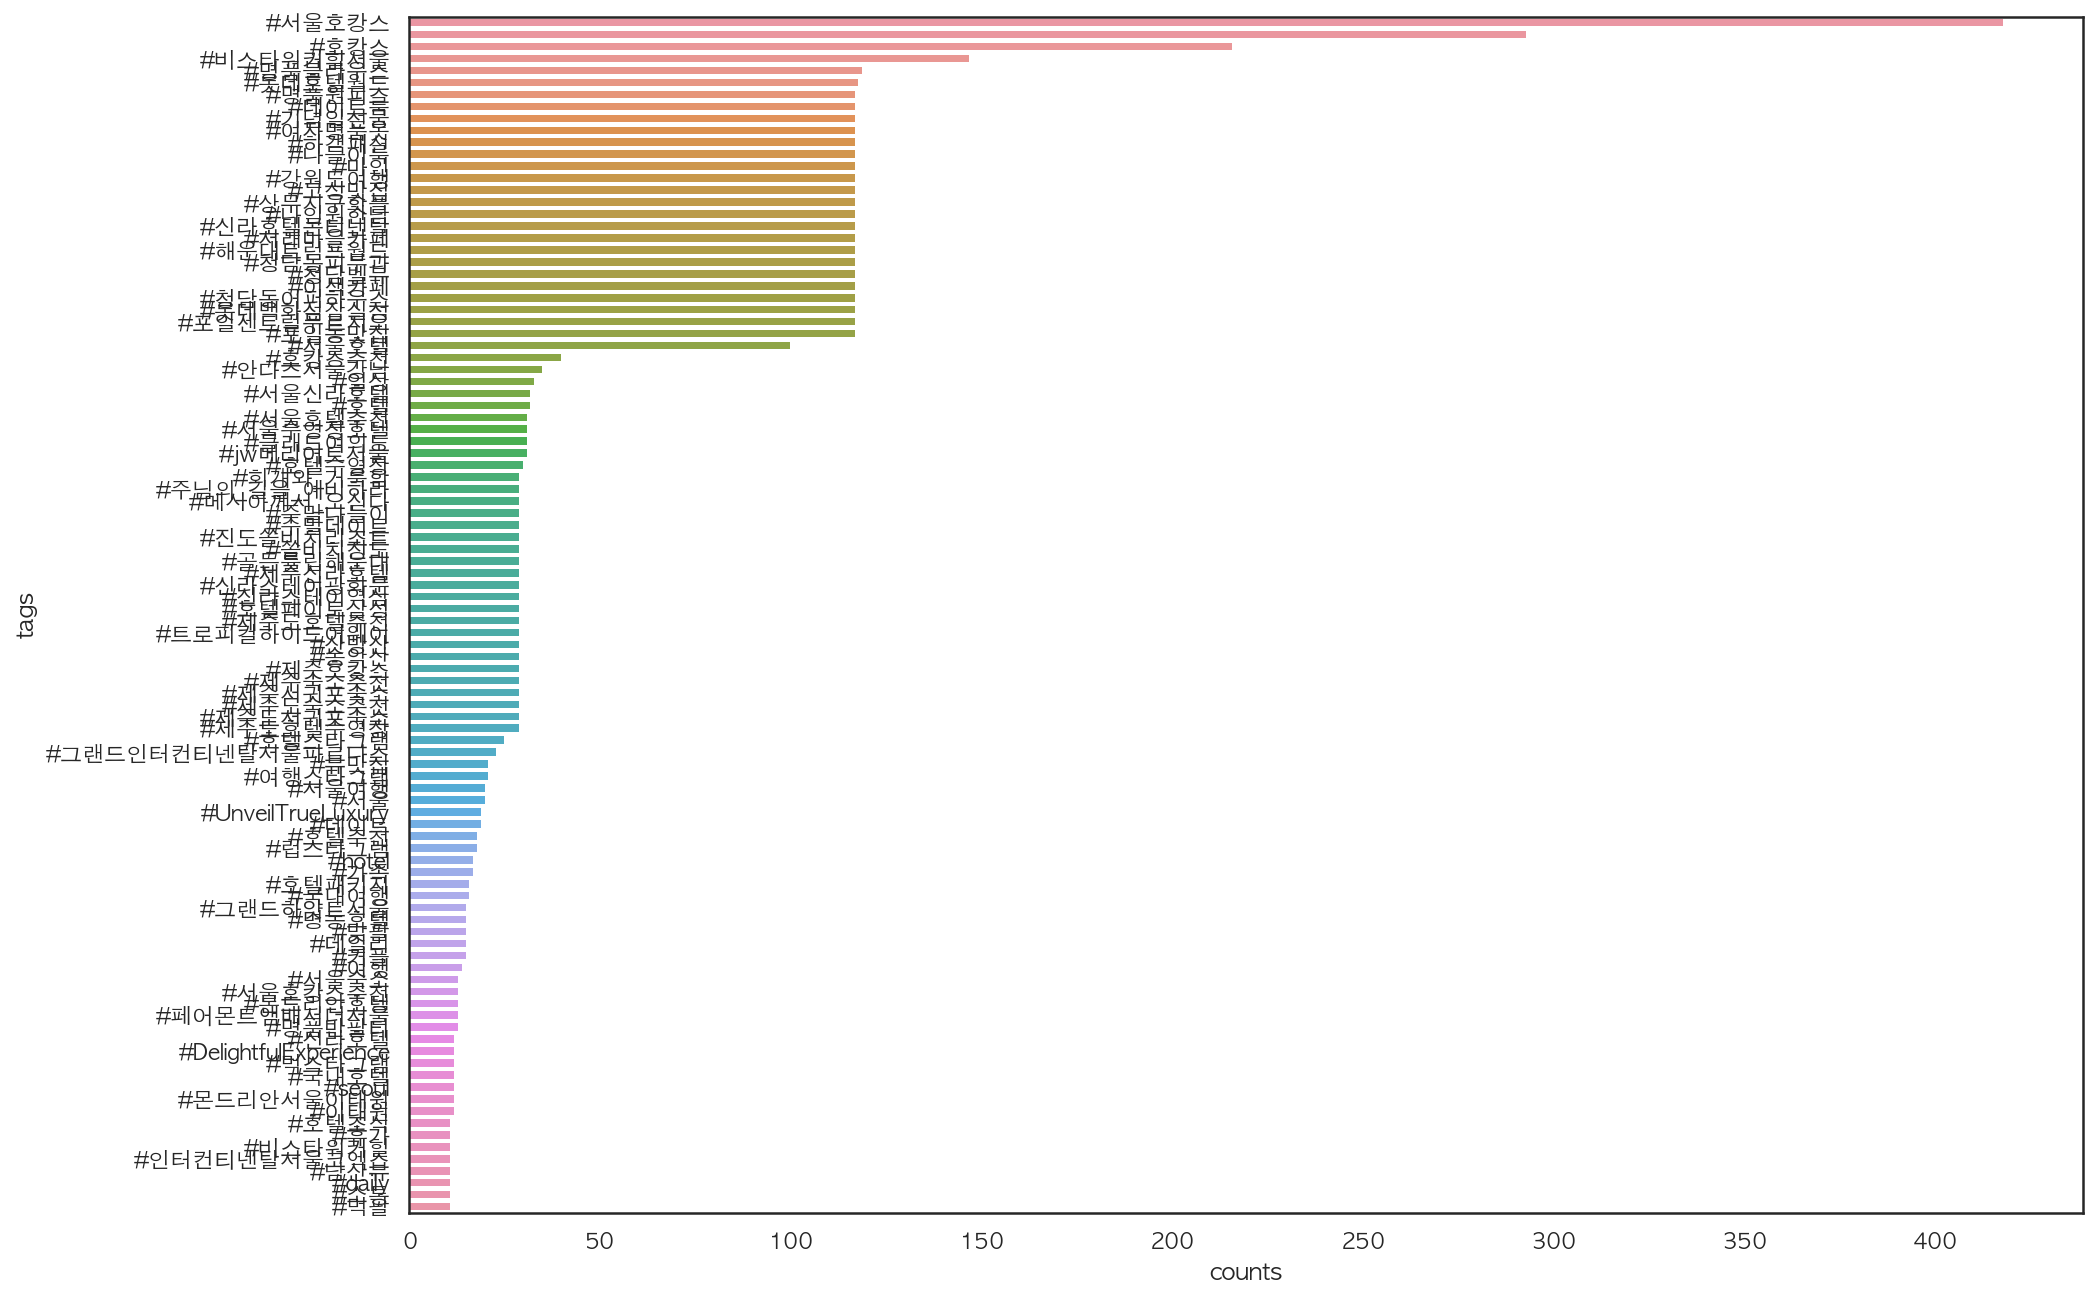

In [16]:
# 막대그래프 그려주기 
plt.figure(figsize = (15,11))
sns.barplot(x='counts', y='tags', data = tag_counts_df)
plt.show()

In [17]:
# 두번째 방법 태그 빈도율 나타내기 
import nltk
from konlpy.corpus import kobill

In [18]:
ko = nltk.Text(tags_total, name = '서울호캉스')

In [19]:
print(len(ko.tokens))
print(len(set(ko.tokens)))
ko.vocab()

9760
2783


FreqDist({'#서울호캉스': 418, '': 293, '#호캉스': 216, '#비스타워커힐서울': 147, '#명품블라우스': 119, '#롯데호텔월드': 118, '#명품원피스': 117, '#데이트룩': 117, '#기념일선물': 117, '#여자명품옷': 117, ...})

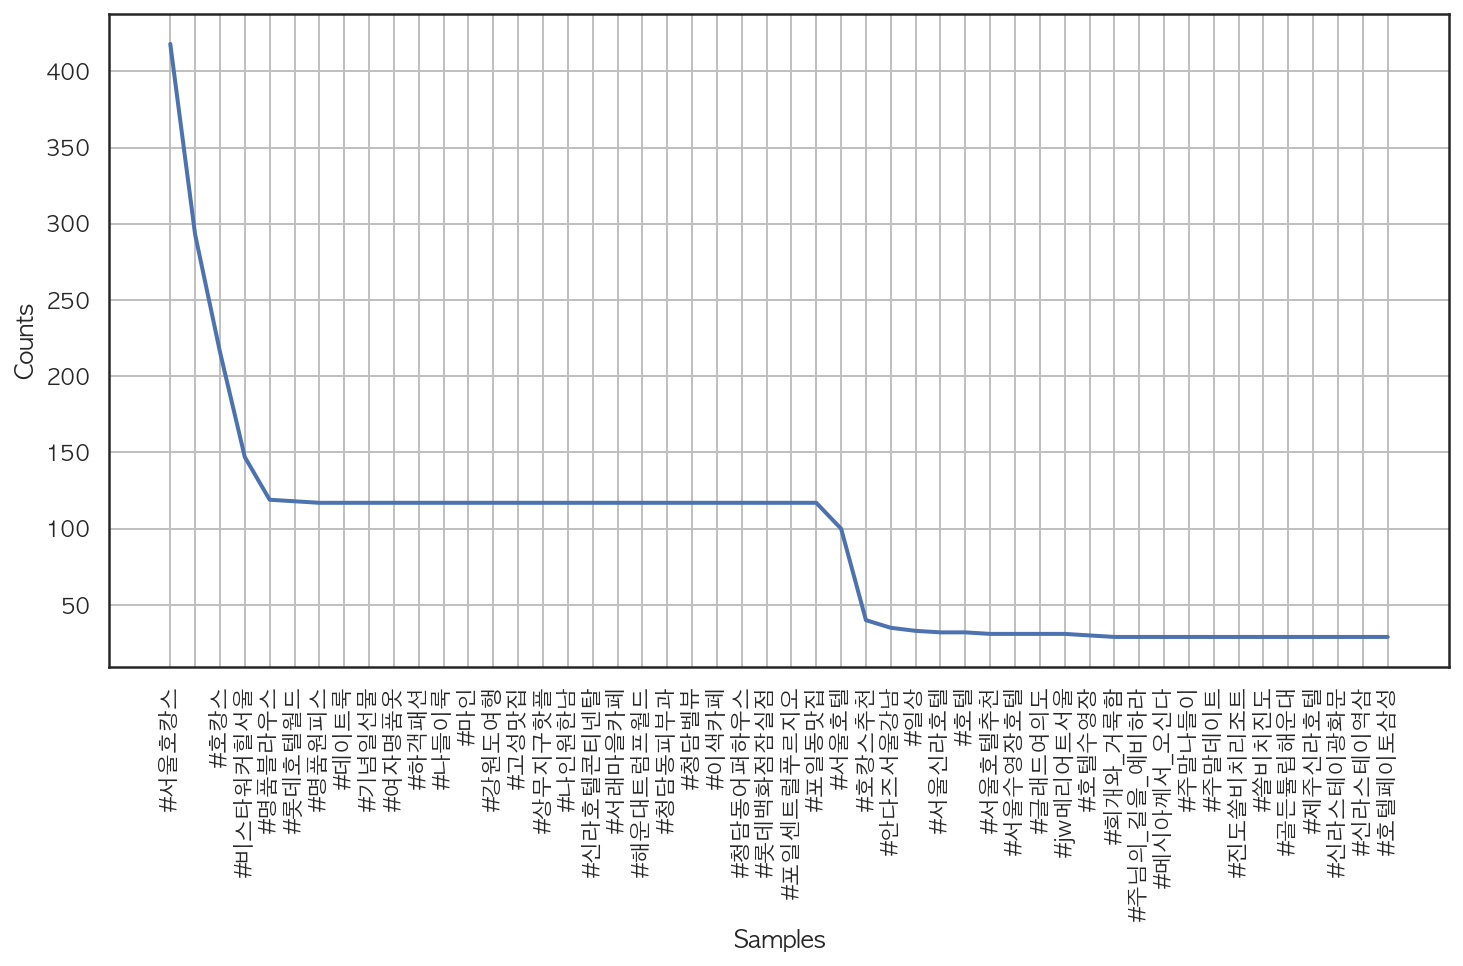

In [20]:
plt.figure(figsize=(12,6))
ko.plot(50)
plt.show()

In [21]:
# wordcloud 그리기 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import platform

In [22]:
# 윈도우 맥 환경에 맞게 글꼴 설정 
if platform.system() == 'Windows':   
    font_path = "c:/Windows/Fonts/malgun.ttf"
elif platform.system() == "Darwin":  
    font_path = "/Users/$USER/Library/Fonts/AppleGothic.ttf"

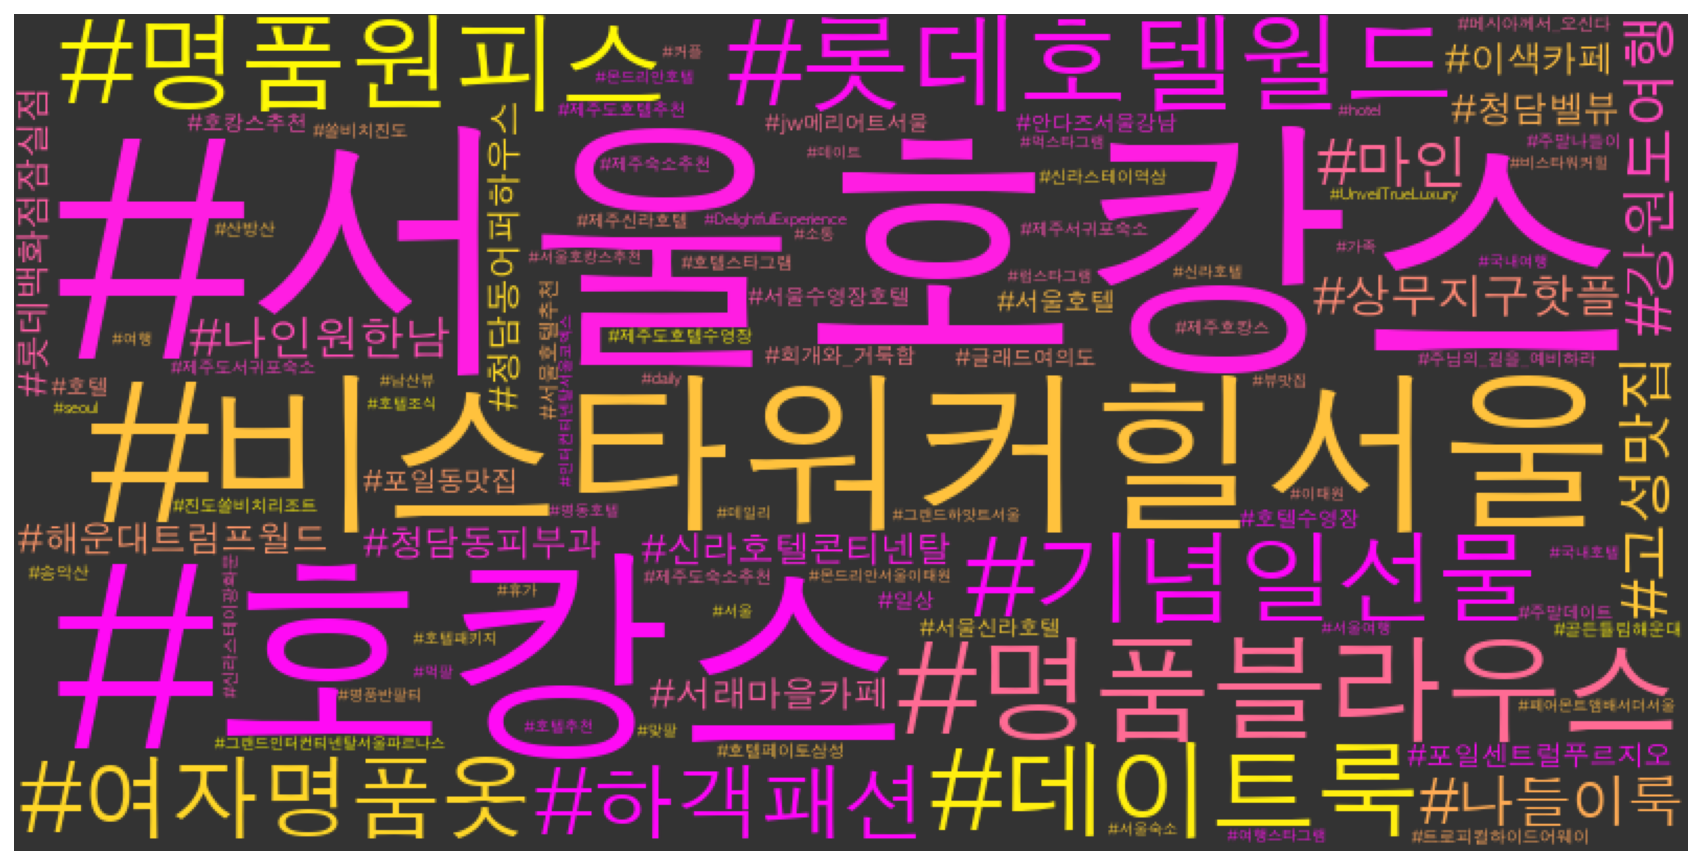

In [27]:
# 그리기
wordcloud = WordCloud(font_path=font_path,
                      colormap='spring',
                     background_color="#333333",
                     max_words=100,
                     relative_scaling=0.3,
                     width=800,
                     height=400).generate_from_frequencies(tag_counts)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud )
plt.axis('off')
plt.show()

- 가장많이 노출된 해시태그는 '서울호캉스', '호캉스', '명품블라우스', '명품원피스', '데이트룩', '비스타워커힐서울', '롯데호텔월드'로 많이 언급이 되었다.
- 해당 노출 해시태그로 보아 서울에서 호캉스를 주로 즐기고, 호캉스를 즐길 때 원피스, 블라우스, 데이트룩 등 옷이 많이 언급된 것으로 보아 방을 잡아 파티를 여는 호캉스가 아닌 연인과 같이 보내는 것을 선호하며, 주로 고급 호텔에서 호캉스를 즐기는 것을 알 수 있다.
- 하지만 여기서 아쉬운 점은 인스타를 크롤링 할 때 서울 호텔만 검색되는 것이 아닌 다른 지역도 검색이 되어 정확하게 크롤링 되지 않은 점이 아쉽다.

In [28]:
# 이미지에 워드클라우드 설정해보기 
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from wordcloud import ImageColorGenerator

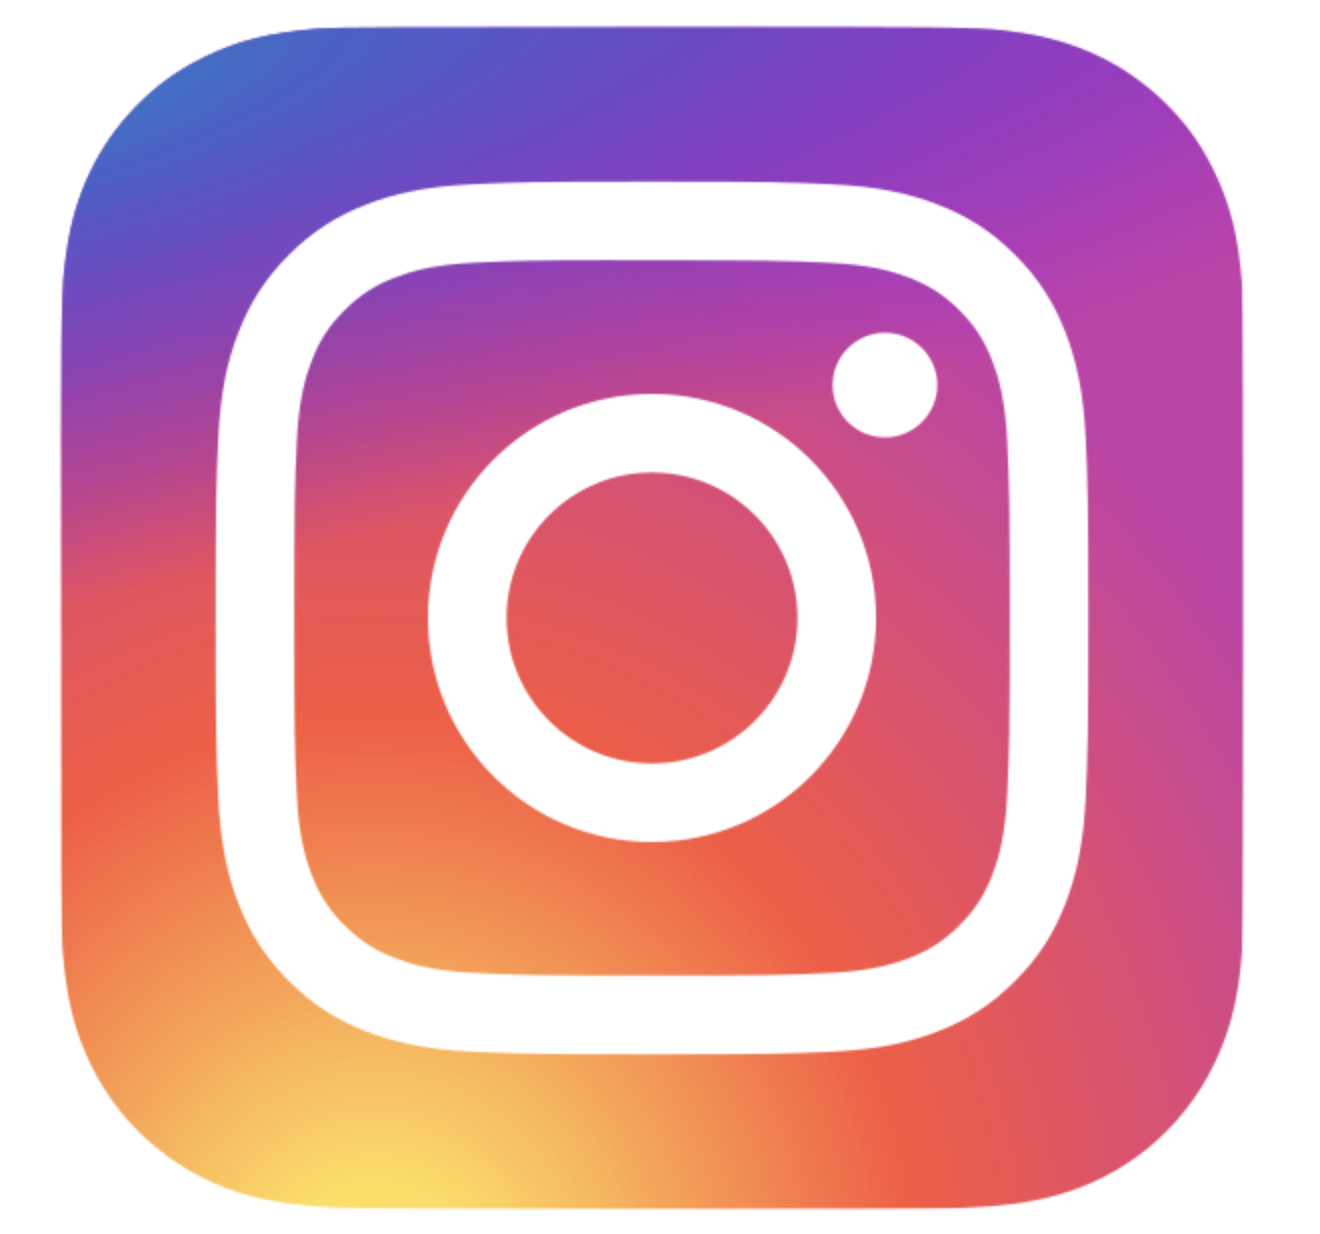

In [29]:
image = Image.open("datas/instagram.png")
image

In [30]:
mask = np.array(image)
mask[0][0]

array([255, 255, 255, 255], dtype=uint8)

In [37]:
fog_machine = WordCloud(mask=mask,
                     min_font_size=14,
                     colormap='Reds')

fog_machine.generate_from_frequencies(word_counts)

fog_machine.to_image()

NameError: name 'word_counts' is not defined

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud.recolor(color_func=image_colors),
          interpolation='bilinear')
plt.axis('off')
plt.show()

ValueError: ImageColorGenerator is smaller than the canvas

<Figure size 720x720 with 0 Axes>